### Introduction

In this tutorial we will explore the use of generative AI for denovo molecular design.  We will use a generative model trained on SMILES to produce the structures of new molecules.  In this case, we will use [SMILES-RNN](https://github.com/MorganCThomas/SMILES-RNN), a generative model developed by Morgan Thomas. We will then explore a typical drug discovery scenario where we start with a known compound and generate analogs.  Many of the analogs contain structural errors and problematic functionality.  We will examine several strategies for identifying and removing these analogs from the dataset. 

### 0. Setup
Install the necessary Python libraries.   This takes about 3 minutes on Google Colab.

In [1]:
import sys, subprocess
 
IN_COLAB = "google.colab" in sys.modules
 
if IN_COLAB:
    from IPython.utils import io
 
    print("In Google Colab - installing required packages...")
 
    with io.capture_output():
        subprocess.run(
            ['pip', 'install', 'smiles-rnn', 'molscore', 'useful_rdkit_utils', 'mols2grid', 'seaborn']
        )
 
    print("Done!")

Import the libraries we'll be using

In [106]:
from six.moves import urllib                            # downloading files
from glob import glob                                   # getting directory listings
import os                                               # sorting directory listings
import pandas as pd                                     # data manipulation
from tqdm.auto import tqdm                              # progress bars
from rdkit import Chem                                  # molecule manipulation
from rdkit.Chem.Draw import MolsToGridImage             # molecule grid images
import useful_rdkit_utils as uru                        # ring system checks
from rdkit.Chem import rdFingerprintGenerator           # chemical fingerprints
from rdkit.DataStructs import BulkTanimotoSimilarity    # chemical fingerprints
import seaborn as sns                                   # plotting
import matplotlib.ticker as ticker                      # plot formatting
import mols2grid                                        # interactive molecule viewer
import json                                             # read the configuration file 
from rdkit.rdBase import BlockLogs                      # prevent the RDKit from generating lots of error messages

Enable progress bars for Pandas **progress_apply**. 

In [2]:
tqdm.pandas()

Grab the script the runs reinforcement learning from the [SMILES-RNN](https://github.com/MorganCThomas/SMILES-RNN) GitHub repository. 

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/MorganCThomas/SMILES-RNN/main/scripts/reinforcement_learning.py", "reinforcement_learning.py")

('reinforcement_learning.py', <http.client.HTTPMessage at 0x38f0bc5d0>)

Grab the checkpoint file with the prior distributions from ChEMBL 28. 

In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/MorganCThomas/SMILES-RNN/main/priors/ChEMBL28pur.ckpt","ChEMBL28pur.ckpt")

('ChEMBL28pur.ckpt', <http.client.HTTPMessage at 0x38f0beed0>)

Grab a scoring configuration file. 

In [5]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/generative/data/fragment_005_similarity.json","fragment_005_similarity.json")

('fragment_005_similarity.json', <http.client.HTTPMessage at 0x38f208290>)

Download the results from a previous run.  We'll use this if we don't want to wait for a reinforcement learning run to complete. 

In [6]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/generative/data/2024_08_26_SMILES-RNN_fragment_005_similarity.tar.gz","2024_08_26_SMILES-RNN_fragment_005_similarity.tar.gz")

('2024_08_26_SMILES-RNN_fragment_005_similarity.tar.gz',
 <http.client.HTTPMessage at 0x38f209550>)

Unpack the results from the previous run. 

In [7]:
!tar -zxf 2024_08_26_SMILES-RNN_fragment_005_similarity.tar.gz

### 1. Introduction
In this notebook, we'll be use a generative model to generate structures of molecules similar to the reference molecule below.  This scenario arises frequently in drug discovery. We have a screening hit or a lead molecule and we'd like figure out how to modulate its properties or improve it's activity. One way to do this is to generate a set of analogs and use one or more computational models to evaluate the analogs.  This computational evaluation could involve docking, machine learning models or any of several other techniques. 

We begin by using a reinforcement learning algorithm to generate a set molecules from a **prior** distribution trained on molecules from the ChEMBL database.  Molecules are sampled from this prior and each molecule is scored based on its similarity to the reference molecule below.  These similarities are used to update the prior so that the generated molecules continue to look more like the reference molecule. 

If you want to generate analogs for a different molecule, just change **ref_smiles** below. 

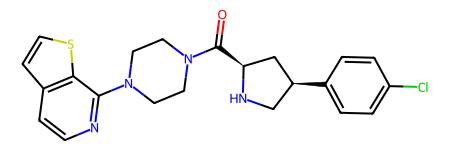

In [133]:
ref_smiles = "Clc1ccc(cc1)[C@H]2CN[C@H](C2)C(=O)N3CCN(CC3)c4nccc5ccsc45"
ref_mol = Chem.MolFromSmiles(ref_smiles)
ref_mol

### 2. Run Reinforcement Learning (RL)

Modify the configuration file used by SMILES-RNN.  The file is written in the JSON format, which allows it to be read directly into a Python dictionary.  We read the file and put its contents into a dictionary called **input_dict**.  We can then modify one field in the dictionary to insert the SMILES we are using for molecule generation.  Then we write a new configuration file called **smiles_rnn_config.json** that we will use in the next step. 

In [136]:
# read the default configuration file 
config_file_name = "fragment_005_similarity.json"
with open(config_file_name) as ifs:
    input_dict = json.load(ifs)
# change the SMILES in input_dict
input_dict['scoring_functions'][0]['parameters']['ref_smiles'] = [ref_smiles]
# write the new configuration file 
new_config_file_name = "smiles_rnn_config.json"
with open(new_config_file_name,"w") as ofs:
    json.dump(input_dict, ofs, indent=5)

The command below runs reinforcement learning.  This takes about 5 minutes.  To run this, remove the "#" character from the beginning of the line below. If you're pressed for time, you don't need to do this.  The lines below will work with files we downloaded earlier. 

In [163]:
#!python reinforcement_learning.py -p ChEMBL28pur.ckpt -m smiles_rnn_config.json --model RNN -d gpu RV2

### 3. Retrieve RL Results
Find the most recent result set. 

In [138]:
files = glob("*SMILES-RNN_fragment_005_similarity*")
files.sort(key=os.path.getmtime,reverse=True)
dir_path = files[0]
dir_path

'2025_03_24_SMILES-RNN_fragment_005_similarity_21_26_02'

Read the scores from the most recent result set into a dataframe. 

In [139]:
df = pd.read_csv(f"{dir_path}/scores.csv")
len(df)

32000

In [140]:
df

,Unnamed: 0,model,task,step,batch_idx,absolute_time,smiles,valid,valid_score,unique,...,filter,score_time,prior,agent,batch_size,rl_strategy,sigma,loss,prior_nll,agent_nll
0,0,RNN,fragment_005_similarity,0,0,0.709453,O=C1NCC2CCc3c(-c4ccccc4)cc(NCCN4CCCCC4)c1c32,True,1,True,...,1.0,0.027160,ChEMBL28pur.ckpt,ChEMBL28pur.ckpt,128,RV,120,2042.2129,33.154570,33.154580
1,1,RNN,fragment_005_similarity,0,1,0.709453,O=C(O)c1ccc(N2CCN(S(=O)(=O)c3ccc(Cc4ccccc4)cc3...,True,1,True,...,1.0,0.027160,ChEMBL28pur.ckpt,ChEMBL28pur.ckpt,128,RV,120,3715.1924,27.764763,27.764755
2,2,RNN,fragment_005_similarity,0,2,0.709453,COc1ccc2c(c1)CCNCC2C,True,1,True,...,1.0,0.027160,ChEMBL28pur.ckpt,ChEMBL28pur.ckpt,128,RV,120,1301.6531,17.353498,17.353497
3,3,RNN,fragment_005_similarity,0,3,0.709453,CS(=O)(=O)c1ccc(C2=CC(=Cc3cnccn3)CC2)cc1,True,1,True,...,1.0,0.027160,ChEMBL28pur.ckpt,ChEMBL28pur.ckpt,128,RV,120,2644.8982,26.732885,26.732887
4,4,RNN,fragment_005_similarity,0,4,0.709453,Oc1ccc(C=Cc2coc3ncccc23)cc1,True,1,True,...,1.0,0.027160,ChEMBL28pur.ckpt,ChEMBL28pur.ckpt,128,RV,120,2148.7990,24.108020,24.108023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31995,31995,RNN,fragment_005_similarity,249,123,229.903742,O=C(c1ccc(F)cc1)N1CCN(c2ccccn2)CC1,True,1,False,...,1.0,0.013074,ChEMBL28pur.ckpt,ChEMBL28pur.ckpt,128,RV,120,4754.2485,19.848444,0.288861
31996,31996,RNN,fragment_005_similarity,249,124,229.903742,O=C(c1ccc(F)cc1)N1CCN(c2ccccn2)CC1,True,1,False,...,1.0,0.013074,ChEMBL28pur.ckpt,ChEMBL28pur.ckpt,128,RV,120,4754.2485,19.848444,0.288861
31997,31997,RNN,fragment_005_similarity,249,125,229.903742,O=C(c1ccc(F)cc1)N1CCN(c2ccccn2)CC1,True,1,False,...,1.0,0.013074,ChEMBL28pur.ckpt,ChEMBL28pur.ckpt,128,RV,120,4946.7085,19.818668,1.640867
31998,31998,RNN,fragment_005_similarity,249,126,229.903742,O=C(c1ccc(F)cc1)N1CCN(c2ccccn2)CC1,True,1,False,...,1.0,0.013074,ChEMBL28pur.ckpt,ChEMBL28pur.ckpt,128,RV,120,4754.2485,19.848444,0.288861


### 4. Remove Duplicate Results
Remove duplicate molecules

In [141]:
df_unique = df.drop_duplicates(subset=["smiles"]).copy()
len(df_unique)

9267

Let's make one more check for duplicates.  To do this, we'll first add an RDKit molecule to the dataframe, then use that molecule to generate a SMILES string. Note that when we execute the cell below, we get several error messages. This is because not all the SMILES the RNN generates are valid.  However, we are using the [BlockLogs](https://www.rdkit.org/docs/source/rdkit.rdBase.html) function from the RDKit suppress the warning messages. This an example of a [context manager](https://book.pythontips.com/en/latest/context_managers.html), a very usefule Python feature. We'll take care of the invalid molecules below. 

In [142]:
with BlockLogs():
    df_unique['mol'] = df_unique.smiles.progress_apply(Chem.MolFromSmiles)

  0%|          | 0/9267 [00:00<?, ?it/s]

As we saw above, there were numerous invalid SMILES.  Let's see how many SMILES failed to convert to molecules. 

In [143]:
sum(df_unique.mol.isna())

586

Let's remove the invalid molecules from the dataframe. 

In [144]:
df_unique_ok = df_unique.dropna(subset=["mol"]).copy()
len(df_unique_ok)

8681

One more check for duplicates.  We'll convert the molecules to SMILES and check for duplicates. 

In [145]:
df_unique_ok['cansmi'] = df_unique_ok.mol.progress_apply(Chem.MolToSmiles)

  0%|          | 0/8681 [00:00<?, ?it/s]

Compare the length of the dataframe with the number of unique SMILES.  These are the same, which is great. 

In [146]:
len(df_unique_ok),len(df_unique_ok.cansmi.unique())

(8681, 8681)

### 5. Remove Molecules With Questionable Ring Systems
While we removed molecules that violate standard rules of valence, there still may be some molecules that are not chemically stable.  One way to identify these is to compare the ring systems in the generated molecules with those in the ChEMBL database.  If a molecule contains a ring system not in ChEMBL, that molecule is probably unstable or very difficult to sythesize. This [blog post](https://practicalcheminformatics.blogspot.com/2022/12/identifying-ring-systems-in-molecules.html) has more information ring system analysis. The code below adds two columns to the dataframe. 
* min_ring - the ring system in each molecule that occurs least frequently
* min_freq - the frequency with which **min_ring** occurs  

In [147]:
ring_system_lookup = uru.RingSystemLookup()
df_unique_ok['ring_systems'] = df_unique_ok.mol.progress_apply(ring_system_lookup.process_mol)
df_unique_ok[['min_ring','min_freq']] = [uru.get_min_ring_frequency(x) for x in df_unique_ok.ring_systems]

  0%|          | 0/8681 [00:00<?, ?it/s]

Let's see how many molecules contain ring systems that occur fewer than 100 times in ChEMBL. 

In [148]:
len(df_unique_ok.query("min_freq < 100"))

960

Put the molecules with questionable ring systems into another dataframe so we can take a closer look.  We are looking for molecules with **min_freq** < 100 and **min_freq** >= 0.   We add the ">= 0" to retain acyclic molecules, whose **min_freq** values are set to -1. 

In [149]:
bad_ring_df = df_unique_ok.query("min_freq < 100 and min_freq >= 0")

We'll take a look at a few of these, highlighting the questionable ring systems.  For simplictiy, let's grab the first 16 rows in **df_unique_ok**. 

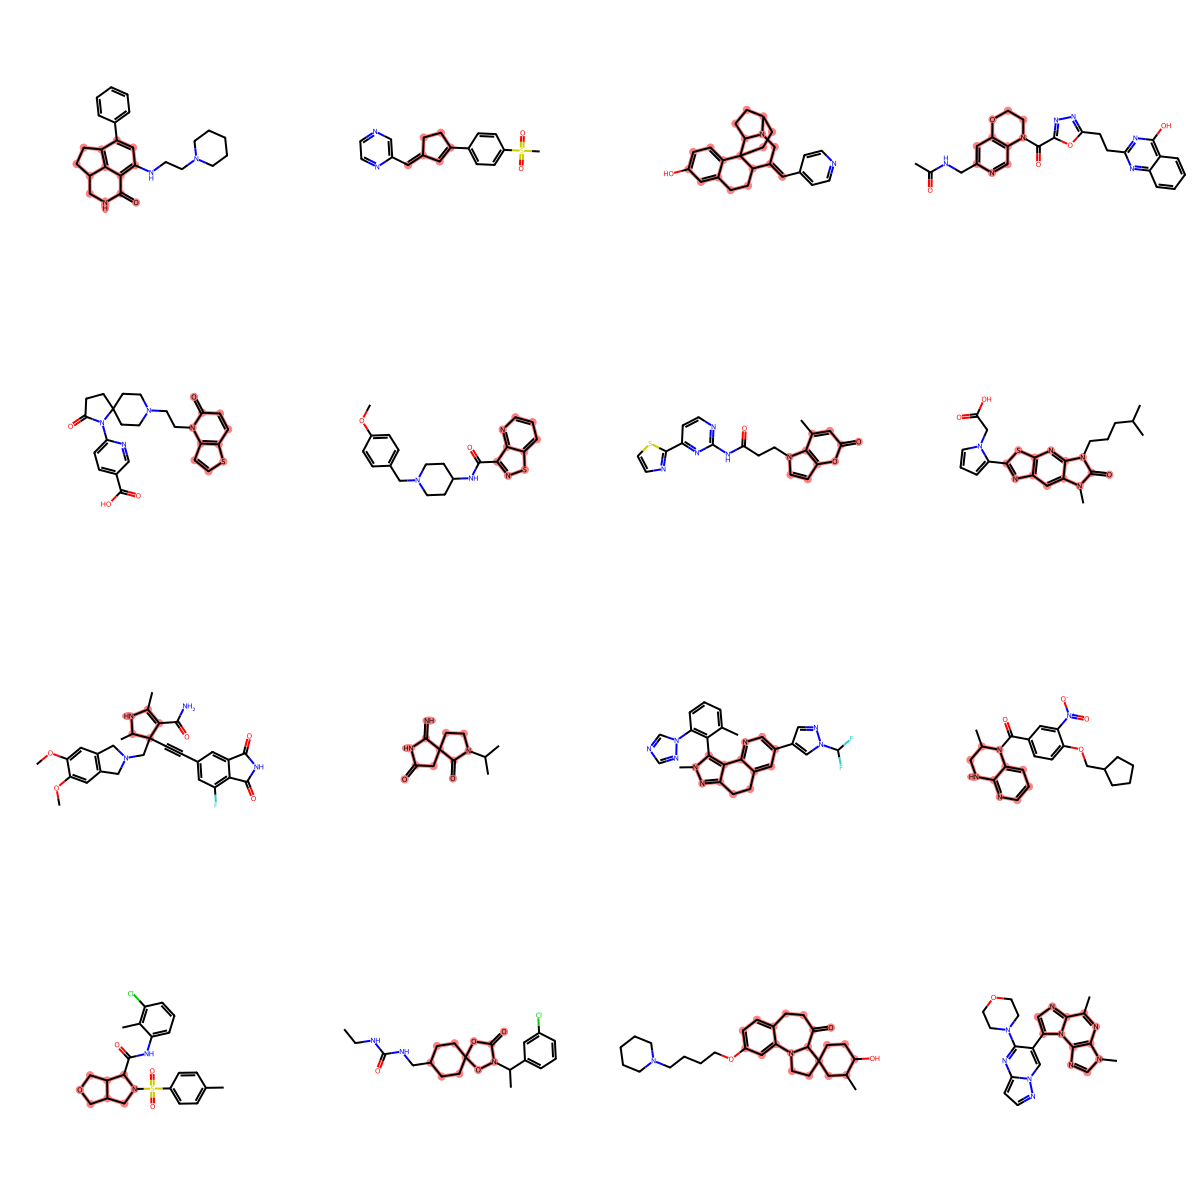

In [150]:
mols_to_show = 16
match_atom_list = [x.GetSubstructMatch(Chem.MolFromSmiles(y)) for x,y in bad_ring_df[["mol","min_ring"]].head(mols_to_show).values]
MolsToGridImage(bad_ring_df.mol.values[:16],molsPerRow=4,useSVG=False,highlightAtomLists=match_atom_list,subImgSize=(300,300))

After examining the image above, we can be confident that we are indeed removing questionable ring systems.  Let's remove these molecules from **df_unique_ok**.  We'll add "or min_freq" < 0" to retain the acyclic molecules. 

In [151]:
df_unique_ok_ring = df_unique_ok.query("min_freq > 100 or min_freq < 0").copy()
len(df_unique_ok_ring)

7720

At this point we've removed the molecules with questionable ring systems, but we still have some molecules with potentially reactive functionality.  We can remove these using the REOS (Rapid Elimination of Swill) filters available in the useful_rdkit_utils package.  For more information on functional group filters, see this [blog post](https://practicalcheminformatics.blogspot.com/2018/08/filtering-chemical-libraries.html).

In [152]:
reos = uru.REOS()
df_unique_ok_ring[["rule_set","rule"]] = df_unique_ok_ring.mol.progress_apply(reos.process_mol).to_list()

  0%|          | 0/7720 [00:00<?, ?it/s]

We can use **value_counts** to see which rules eliminated the largest number of molecules. 

In [153]:
df_unique_ok_ring.rule.value_counts()

rule
ok                                              7586
I5 Thiols                                         61
R17 acylhydrazide                                 14
I6 Epoxides, Thioepoxides, Aziridines             12
R18 Quaternary C, Cl, I, P or S                   11
I16 Betalactams                                    8
R16 beta carbonyl quaternary Nitrogen              4
I13 Cyanamides                                     4
R24 Isonitrile                                     4
I12 Thioesters                                     3
R2 Acid halides                                    3
R11 Isocyanates & Isothiocyanates                  2
R9 Paranitrophenyl esters                          1
I14 Four membered lactones                         1
R21 Nitroso                                        1
R27 Acyl cyanides                                  1
R26 Cyanohydrins                                   1
R7 Peroxides                                       1
I1 Aliphatic methylene chains 7 or more l

In [154]:
df_unique_ok_ring_reos = df_unique_ok_ring.query("rule == 'ok'").copy()

Now let's see how similar the molecules we generated are to the molecules we started with.  We can do this by generating fingerprints for the generated molecules and calculating the Tanimoto similarity to the starting molecule. 

In [155]:
fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=4096,countSimulation=True)
df_unique_ok_ring_reos['fp'] = df_unique_ok_ring_reos.mol.progress_apply(fp_gen.GetFingerprint)

  0%|          | 0/7586 [00:00<?, ?it/s]

Generate a fingerprint for the starting molecule 

In [156]:
ref_fp = fp_gen.GetFingerprint(ref_mol)

Calculate the similarity of the generated molecules to the reference. 

In [157]:
df_unique_ok_ring_reos['fp_sim'] = BulkTanimotoSimilarity(ref_fp,df_unique_ok_ring_reos.fp.values)

The molecule generation process proceeds over 250 steps with 128 molecules generated at each step.  Let's make a box plot of step vs similarity to the reference molecule. From the plot below, we can see a couple things. 
* The mean similarity at each step increases for the first ~80 steps, then levels off.
* Steps 100-250 are sparse, this is due to the fact that we removed duplicate structures above.  After step 100, most of the generated structures are duplicates. 

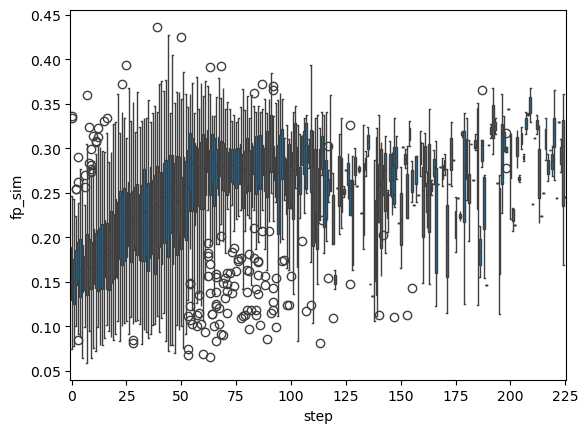

In [158]:
ax = sns.boxplot(x="step",y="fp_sim",data=df_unique_ok_ring_reos)
ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

In many cases, we will want to perform some further analysis on the the generated analogs.  For instance, we could select a subset of the analogs and dock them into a protein crystal structure to identify analogs which could bind to a specific protein target.  Since methods like docking tend to be more computationally expensive, we may want to cluster the molecules to identify a representative subset.     
We begin by using a molecular similarity cutoff to select analogs similar to the input molecule.  When using Morgan fingerprints as a measure of molecular similarity, 0.35 is a widely accepted cutoff for similar molecules. 

In [159]:
similar_df = df_unique_ok_ring_reos.query("fp_sim >= 0.35").copy()

After selecting the similar molecules, we can custer using the same similarity cutoff. 

In [160]:
similar_df['cluster'] = uru.taylor_butina_clustering(similar_df.fp.values,cutoff=0.35)

Finally, we can see how many molecules are in each cluster.  

In [161]:
similar_df.cluster.value_counts()

cluster
0     12
1      9
2      5
3      4
7      3
5      3
4      3
10     2
9      2
12     2
17     2
6      2
36     1
8      1
19     1
20     1
21     1
22     1
23     1
24     1
25     1
26     1
13     1
41     1
40     1
27     1
28     1
11     1
29     1
30     1
31     1
32     1
14     1
42     1
15     1
33     1
34     1
39     1
38     1
16     1
37     1
35     1
18     1
Name: count, dtype: int64

The code below allows us to view a specific cluster. 

In [162]:
cluster_num = 2
mols2grid.display(similar_df.query("cluster == @cluster_num"),smiles_col="smiles",subset=["img"])

MolGridWidget()